Checking GPU availability...
GPU is available: /physical_device:GPU:0


Processing Images: 100%|██████████| 45/45 [00:00<00:00, 491.74it/s]


Training CNN...
Epoch 1/100
55/57 [===========================>..] - ETA: 0s - loss: 3.4946 - accuracy: 0.6818
Epoch 1: val_accuracy improved from -inf to 0.27778, saving model to model_outputs/CNN_best.h5
57/57 [==============================] - 1s 9ms/step - loss: 3.4393 - accuracy: 0.6834 - val_loss: 5.0721 - val_accuracy: 0.2778
Epoch 2/100
52/57 [==========================>...] - ETA: 0s - loss: 1.4998 - accuracy: 0.8065
Epoch 2: val_accuracy did not improve from 0.27778
57/57 [==============================] - 0s 6ms/step - loss: 1.5193 - accuracy: 0.8060 - val_loss: 15.0196 - val_accuracy: 0.2778
Epoch 3/100
50/57 [=========================>....] - ETA: 0s - loss: 1.4738 - accuracy: 0.8125
Epoch 3: val_accuracy improved from 0.27778 to 0.41667, saving model to model_outputs/CNN_best.h5
57/57 [==============================] - 0s 7ms/step - loss: 1.4342 - accuracy: 0.8149 - val_loss: 11.8329 - val_accuracy: 0.4167
Epoch 4/100
54/57 [===========================>..] - ETA: 0s - los

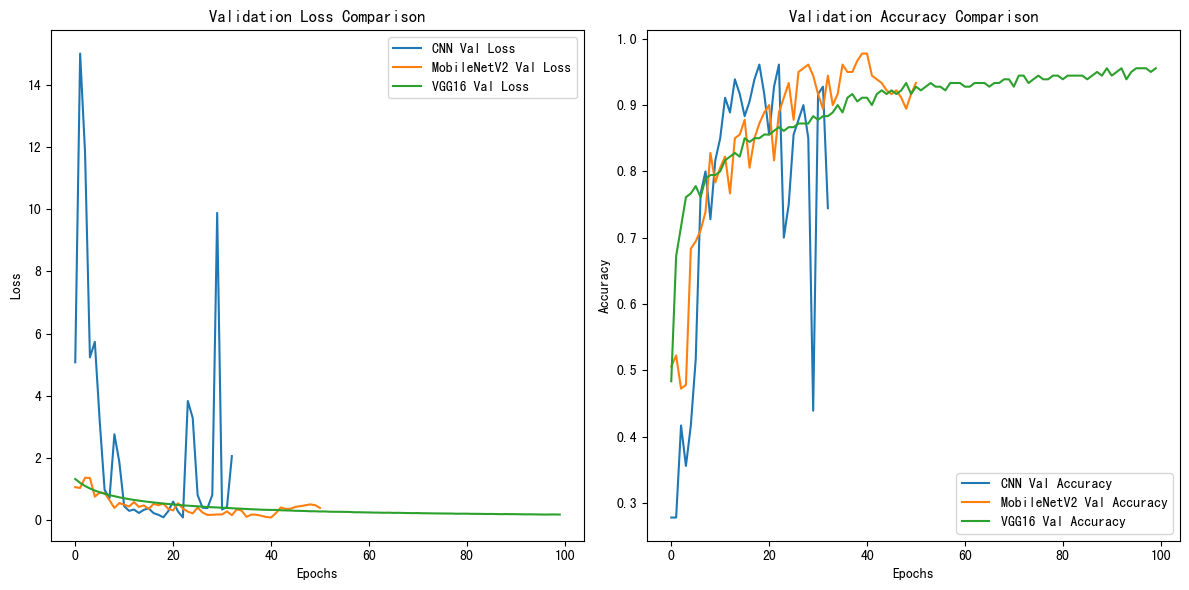

In [16]:
import os
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2, VGG16
from tqdm import tqdm
import pandas as pd

# Check GPU availability
print("Checking GPU availability...")
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"GPU is available: {gpus[0].name}")
    tf.config.experimental.set_memory_growth(gpus[0], True)
else:
    print("GPU is not available. Using CPU.")

# Global parameters
IMG_HEIGHT, IMG_WIDTH = 128, 128  # Image resizing
BATCH_SIZE = 16                  # Batch size
EPOCHS = 100                      # Number of epochs
data_dir = "weather"             # Dataset directory
output_dir = "model_outputs"     # Output directory for saving models

# Check and create output directory
os.makedirs(output_dir, exist_ok=True)

# Step 1: Load data
def load_data(data_dir):
    file_paths, labels = [], []
    for label_folder in tqdm(os.listdir(data_dir), desc="Scanning Folders"):
        label_folder_path = os.path.join(data_dir, label_folder)
        if os.path.isdir(label_folder_path):
            for file_name in os.listdir(label_folder_path):
                if file_name.endswith(('.jpg', '.png')):
                    file_paths.append(os.path.join(label_folder_path, file_name))
                    labels.append(label_folder)  # Folder name as label
    return file_paths, labels

# Step 2: Data preprocessing
def prepare_dataset(file_paths, labels, label_map, batch_size):
    def process_image(file_path, label):
        image = load_img(file_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
        image = img_to_array(image) / 255.0  # Normalize
        label_encoded = label_map[label]
        return image, label_encoded

    images, encoded_labels = [], []
    for file_path, label in tqdm(zip(file_paths, labels), desc="Processing Images", total=len(file_paths)):
        img, lbl = process_image(file_path, label)
        images.append(img)
        encoded_labels.append(lbl)

    images = np.array(images)
    labels = to_categorical(encoded_labels, num_classes=len(label_map))  # One-hot encoding
    dataset = tf.data.Dataset.from_tensor_slices((images, labels))
    dataset = dataset.shuffle(buffer_size=len(images)).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
    return dataset, images, labels

# Step 3: Build different models
def build_cnn_model(input_shape, num_classes):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

def build_mobilenet_model(input_shape, num_classes):
    base_model = MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')
    base_model.trainable = False
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    # Fine-tuning the last few layers of the base model
    base_model.trainable = True
    fine_tune_at = 100  # Unfreeze the last 100 layers
    for layer in base_model.layers[:fine_tune_at]:
        layer.trainable = False

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

def build_vgg16_model(input_shape, num_classes):
    base_model = VGG16(input_shape=input_shape, include_top=False, weights='imagenet')
    base_model.trainable = False
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    # Fine-tuning the last few layers of the base model
    base_model.trainable = True
    fine_tune_at = 100  # Unfreeze the last 100 layers
    for layer in base_model.layers[:fine_tune_at]:
        layer.trainable = False

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Train and evaluate model
def train_and_evaluate(model, train_dataset, val_dataset, val_images, val_labels, model_name):
    print(f"Training {model_name}...")
    
    # Callbacks
    checkpoint = tf.keras.callbacks.ModelCheckpoint(os.path.join(output_dir, f"{model_name}_best.h5"), 
                                                     monitor='val_accuracy', 
                                                     save_best_only=True, 
                                                     mode='max', verbose=1)
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    
    history = model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=EPOCHS,
        verbose=1,
        callbacks=[checkpoint, early_stopping]
    )
    print(f"{model_name} training completed.")

    # Save final model
    model_save_path = os.path.join(output_dir, f"{model_name}.h5")
    model.save(model_save_path)
    print(f"{model_name} saved to {model_save_path}.")

    # Test set evaluation
    test_loss, test_accuracy = model.evaluate(val_images, val_labels, verbose=0)
    return history, test_loss, test_accuracy

# Plot comparison between models
def plot_comparison_histories(histories, model_names):
    plt.figure(figsize=(12, 6))

    # Plot validation loss comparison
    plt.subplot(1, 2, 1)
    for history, name in zip(histories, model_names):
        plt.plot(history.history['val_loss'], label=f"{name} Val Loss")
    plt.title("Validation Loss Comparison")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    # Plot validation accuracy comparison
    plt.subplot(1, 2, 2)
    for history, name in zip(histories, model_names):
        plt.plot(history.history['val_accuracy'], label=f"{name} Val Accuracy")
    plt.title("Validation Accuracy Comparison")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()

# Main program
if __name__ == "__main__":
    file_paths, labels = load_data(data_dir)
    label_map = {label: idx for idx, label in enumerate(sorted(set(labels)))}

    train_paths, temp_paths, train_labels, temp_labels = train_test_split(file_paths, labels, test_size=0.2, random_state=42)
    val_paths, test_paths, val_labels, test_labels = train_test_split(temp_paths, temp_labels, test_size=0.2, random_state=42)

    train_dataset, train_images, train_labels_onehot = prepare_dataset(train_paths, train_labels, label_map, BATCH_SIZE)
    val_dataset, val_images, val_labels_onehot = prepare_dataset(val_paths, val_labels, label_map, BATCH_SIZE)
    test_dataset, test_images, test_labels_onehot = prepare_dataset(test_paths, test_labels, label_map, BATCH_SIZE)

    input_shape = (IMG_HEIGHT, IMG_WIDTH, 3)
    num_classes = len(label_map)

    cnn_model = build_cnn_model(input_shape, num_classes)
    mobilenet_model = build_mobilenet_model(input_shape, num_classes)
    vgg16_model = build_vgg16_model(input_shape, num_classes)

    cnn_history, _, _ = train_and_evaluate(cnn_model, train_dataset, val_dataset, val_images, val_labels_onehot, "CNN")
    mobilenet_history, _, _ = train_and_evaluate(mobilenet_model, train_dataset, val_dataset, val_images, val_labels_onehot, "MobileNetV2")
    vgg16_history, _, _ = train_and_evaluate(vgg16_model, train_dataset, val_dataset, val_images, val_labels_onehot, "VGG16")

    plot_comparison_histories([cnn_history, mobilenet_history, vgg16_history], ["CNN", "MobileNetV2", "VGG16"])



Evaluating CNN...


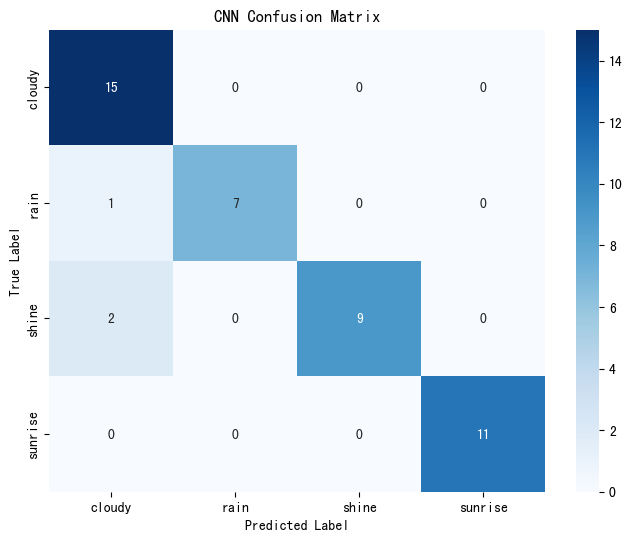

CNN Classification Report:
              precision    recall  f1-score   support

      cloudy       0.83      1.00      0.91        15
        rain       1.00      0.88      0.93         8
       shine       1.00      0.82      0.90        11
     sunrise       1.00      1.00      1.00        11

    accuracy                           0.93        45
   macro avg       0.96      0.92      0.94        45
weighted avg       0.94      0.93      0.93        45


Evaluating MobileNetV2...


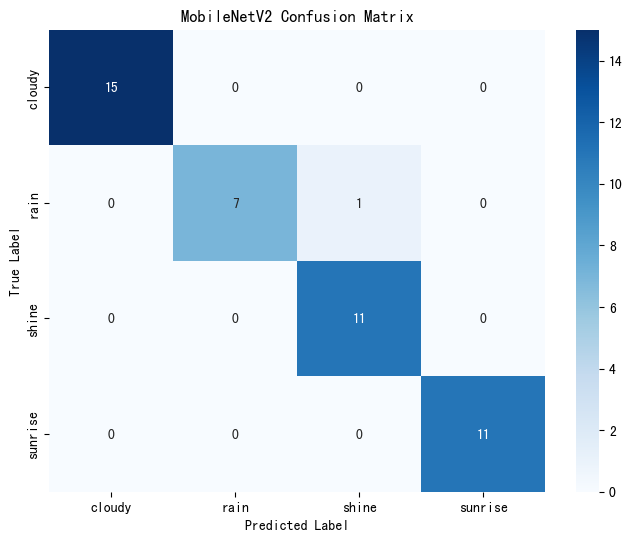

MobileNetV2 Classification Report:
              precision    recall  f1-score   support

      cloudy       1.00      1.00      1.00        15
        rain       1.00      0.88      0.93         8
       shine       0.92      1.00      0.96        11
     sunrise       1.00      1.00      1.00        11

    accuracy                           0.98        45
   macro avg       0.98      0.97      0.97        45
weighted avg       0.98      0.98      0.98        45


Evaluating VGG16...


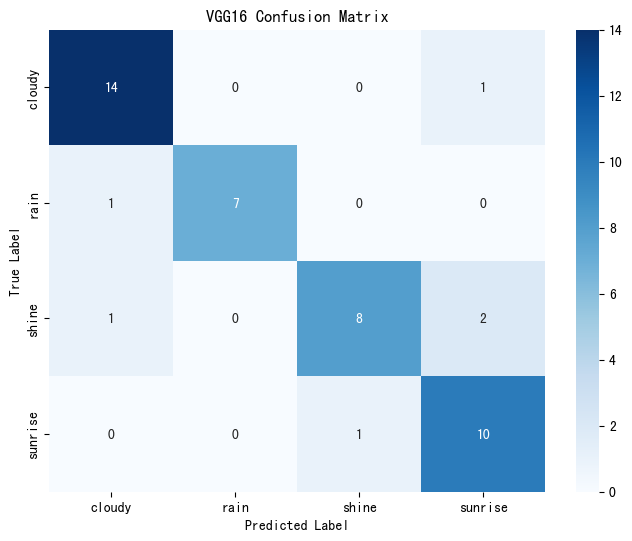

VGG16 Classification Report:
              precision    recall  f1-score   support

      cloudy       0.88      0.93      0.90        15
        rain       1.00      0.88      0.93         8
       shine       0.89      0.73      0.80        11
     sunrise       0.77      0.91      0.83        11

    accuracy                           0.87        45
   macro avg       0.88      0.86      0.87        45
weighted avg       0.87      0.87      0.87        45

Evaluation completed for all models.


In [17]:
# 混淆矩阵和分类报告函数
def evaluate_model_with_confusion_matrix(model, test_images, test_labels_onehot, label_map, model_name):
    print(f"\nEvaluating {model_name}...")
    
    # 获取模型预测
    predictions = model.predict(test_images)
    predicted_labels = np.argmax(predictions, axis=1)
    true_labels = np.argmax(test_labels_onehot, axis=1)
    
    # 混淆矩阵
    cm = confusion_matrix(true_labels, predicted_labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_map.keys(), yticklabels=label_map.keys())
    plt.title(f"{model_name} Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()
    
    # 分类报告
    report = classification_report(true_labels, predicted_labels, target_names=list(label_map.keys()))
    print(f"{model_name} Classification Report:\n{report}")

# 主程序：评估每个模型
if __name__ == "__main__":
    try:
        # 使用混淆矩阵和分类报告评估模型
        evaluate_model_with_confusion_matrix(cnn_model, test_images, test_labels_onehot, label_map, "CNN")
        evaluate_model_with_confusion_matrix(mobilenet_model, test_images, test_labels_onehot, label_map, "MobileNetV2")
        evaluate_model_with_confusion_matrix(vgg16_model, test_images, test_labels_onehot, label_map, "VGG16")
    
        print("Evaluation completed for all models.")
    except Exception as e:
        print(f"Error during evaluation: {e}")


In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np

# 设置图片大小
IMG_HEIGHT, IMG_WIDTH = 128, 128

# 加载训练好的 MobileNetV2 和 CNN 模型
mobilenet_model_path = "model_outputs/MobileNetV2_best.h5"
cnn_model_path = "model_outputs/CNN_best.h5"
mobilenet_model = tf.keras.models.load_model(mobilenet_model_path)
cnn_model = tf.keras.models.load_model(cnn_model_path)

# 加载标签映射
# 这里直接使用训练时的 label_map 
label_map = {label: idx for idx, label in enumerate(sorted(set(labels)))}
reverse_label_map = {v: k for k, v in label_map.items()}

# 载入图片并进行预处理
def process_image(image_path):
    image = load_img(image_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
    image = img_to_array(image) / 255.0  # 归一化处理
    return np.expand_dims(image, axis=0)  # 添加 batch 维度

# 预测并显示图片
def predict_and_show(image_path, model):
    image = process_image(image_path)
    prediction = model.predict(image)  # 模型预测
    predicted_class = np.argmax(prediction)  # 获取预测类别
    predicted_label = reverse_label_map[predicted_class]  # 获取类别名称
    
    # 展示图片和预测结果
    image_to_show = load_img(image_path)  # 加载原图
    plt.imshow(image_to_show)
    plt.title(f"Predicted: {predicted_label}")
    plt.axis('off')
    plt.show()
    
    return predicted_label

# 用户输入图片路径并测试
image_path = input("请输入你的图片路径：")

# 测试 MobileNetV2
print("使用 MobileNetV2 模型进行预测...")
predicted_label_mobilenet = predict_and_show(image_path, mobilenet_model)
print(f"MobileNetV2 预测类别: {predicted_label_mobilenet}")

# 测试 CNN
print("使用 CNN 模型进行预测...")
predicted_label_cnn = predict_and_show(image_path, cnn_model)
print(f"CNN 预测类别: {predicted_label_cnn}")


TypeError: Error when deserializing class 'DepthwiseConv2D' using config={'name': 'expanded_conv_depthwise', 'trainable': False, 'dtype': 'float32', 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'bias_regularizer': None, 'activity_regularizer': None, 'bias_constraint': None, 'depth_multiplier': 1, 'depthwise_initializer': {'class_name': 'GlorotUniform', 'config': {'seed': None}}, 'depthwise_regularizer': None, 'depthwise_constraint': None}.

Exception encountered: Unrecognized keyword arguments passed to DepthwiseConv2D: {'groups': 1}